<a href="https://colab.research.google.com/github/Tejaswini170104/CH5020-Term-paper-presentation/blob/main/CartPole_v1_sarsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import gymnasium as gym
import random
import wandb

# Constants
GAMMA = 0.99
EPSILON_START = 1
EPSILON_MIN = 0.01
MAX_EPISODES = 10000
MAX_STEPS = 500
NUM_RUNS = 5  # Running the experiment 5 times
MAX_REWARD = 500  # Max possible reward in CartPole-v1

# State bounds for normalization
state_bounds = [
    [-4.8, 4.8],  # Cart position
    [-3.0, 3.0],  # Cart velocity
    [-0.418, 0.418],  # Pole angle
    [-3.0, 3.0]   # Pole angular velocity
]
NUM_BINS = [20, 20, 20, 20]  # Number of bins for each state variable

def discretize_state(state):
    """Convert continuous state into discrete bins."""
    bin_indices = []
    for i in range(len(state)):
        bin_width = (state_bounds[i][1] - state_bounds[i][0]) / NUM_BINS[i]
        bin_index = int((state[i] - state_bounds[i][0]) / bin_width)
        bin_index = min(NUM_BINS[i] - 1, max(0, bin_index))  # Keep within bounds
        bin_indices.append(bin_index)
    return tuple(bin_indices)

def choose_action(q_table, state, epsilon):
    """Epsilon-greedy action selection."""
    if random.uniform(0, 1) < epsilon:
        return random.choice([0, 1])  # Random action
    return np.argmax(q_table.get(state, [0, 0]))  # Exploit best known action

def sarsa_q_table(env, alpha, lambda_decay, run_num):
    """SARSA algorithm with discretized states."""
    q_table = {}  # Q-table stored as a dictionary
    rewards_per_episode = []
    regret_per_episode = []

    for episode in range(MAX_EPISODES):
        epsilon = max(EPSILON_MIN, EPSILON_START * np.exp(-lambda_decay * episode))
        state = discretize_state(env.reset()[0])
        action = choose_action(q_table, state, epsilon)
        total_reward = 0

        for _ in range(MAX_STEPS):
            next_state_raw, reward, terminated, truncated, _ = env.step(action)
            next_state = discretize_state(next_state_raw)
            next_action = choose_action(q_table, next_state, epsilon)

            td_target = reward + (GAMMA * q_table.get(next_state, [0, 0])[next_action] if not (terminated or truncated) else 0)
            q_table.setdefault(state, [0, 0])[action] += alpha * (td_target - q_table[state][action])

            state, action = next_state, next_action
            total_reward += reward
            if terminated or truncated:
                break

        rewards_per_episode.append(total_reward)
        regret_per_episode.append(MAX_REWARD - total_reward)  # Compute regret

    return rewards_per_episode, regret_per_episode

# --------------------- #
#       W&B SWEEP      #
# --------------------- #

# Define the WandB sweep configuration
sweep_config = {
    "method": "grid",  # Options: "grid", "random", "bayes"
    "metric": {"name": "total_regret", "goal": "minimize"},
    "parameters": {
        "alpha": {"values": [0.1, 0.05, 0.01]},  # Learning rates
        "lambda_decay": {"values": [0.001, 0.005, 0.0005]}  # Decay rates
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep_config, project="RL CartPole SARSA")

def train_sweep():
    """Train SARSA for a single (alpha, lambda_decay) configuration."""
    wandb.init(project="cpsarsa")  # Initialize WandB
    config = wandb.config  # Get current hyperparameters

    alpha = config.alpha
    lambda_decay = config.lambda_decay

    all_rewards = np.zeros((NUM_RUNS, MAX_EPISODES))
    all_regrets = np.zeros((NUM_RUNS, MAX_EPISODES))

    for run in range(NUM_RUNS):
        env = gym.make("CartPole-v1")
        rewards, regrets = sarsa_q_table(env, alpha, lambda_decay, run)
        all_rewards[run, :] = rewards
        all_regrets[run, :] = regrets

    # Compute mean and variance for rewards & regret per episode
    mean_rewards = np.mean(all_rewards, axis=0)
    var_rewards = np.var(all_rewards, axis=0)
    mean_regret = np.mean(all_regrets, axis=0)
    var_regret = np.var(all_regrets, axis=0)

    # Log episode-wise metrics
    for episode in range(MAX_EPISODES):
        wandb.log({
            "episode": episode,
            f"mean_reward_alpha_{alpha}_lambda_{lambda_decay}": mean_rewards[episode],
            f"reward_variance_alpha_{alpha}_lambda_{lambda_decay}": var_rewards[episode],
            f"mean_regret_alpha_{alpha}_lambda_{lambda_decay}": mean_regret[episode],
            f"regret_variance_alpha_{alpha}_lambda_{lambda_decay}": var_regret[episode]
        })

    # Log final performance
    wandb.log({
        f"final_mean_reward_alpha_{alpha}_lambda_{lambda_decay}": mean_rewards[-1],
        f"final_reward_variance_alpha_{alpha}_lambda_{lambda_decay}": var_rewards[-1],
        f"final_total_regret_alpha_{alpha}_lambda_{lambda_decay}": mean_regret[-1],
        f"final_regret_variance_alpha_{alpha}_lambda_{lambda_decay}": var_regret[-1]
    })

# Run the sweep agent for all 9 configurations
wandb.agent(sweep_id, train_sweep)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: y7dexche
Sweep URL: https://wandb.ai/tejaswiniksssn-indian-institute-of-technology-madras/RL%20CartPole%20SARSA/sweeps/y7dexche


wandb: Agent Starting Run: qa83qth3 with config:
wandb: 	alpha: 0.1
wandb: 	lambda_decay: 0.001
wandb: Currently logged in as: tejaswiniksssn (tejaswiniksssn-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
final_mean_reward_alpha_0.1_lambda_0.001,▁
final_regret_variance_alpha_0.1_lambda_0.001,▁
final_reward_variance_alpha_0.1_lambda_0.001,▁
final_total_regret_alpha_0.1_lambda_0.001,▁
mean_regret_alpha_0.1_lambda_0.001,████▇▄▁▃▂▄▄▃▄▃▂▁▃▁▄▂▃▃▄▃▃▃▂▄▄▄▄▃▄▄▁▄▄▃▁▄
mean_reward_alpha_0.1_lambda_0.001,▁▁▂▃▃▅▅▆▄▆▆▆▆▅▆▄▇▆▅▄▆▅▅▄▅▆▆▅▄▄▅▆▅▇█▆▄▅▄▆
regret_variance_alpha_0.1_lambda_0.001,▁▁▁▁▁▁▁▁▁▁▁▇▅▂▅▁█▄▅▁▅▄▂▂▃▄▄▂▁▃▅▁▃▂▂▃▃▂▂▃
reward_variance_alpha_0.1_lambda_0.001,▁▁▁▁▁▁▁▁▄▁▂▇▆▁▄▂▇▅▃▅▄▃▄▃▇▁▆▄▃▅▅█▄▅▅▃▂▅▃▂
episode,9999
final_mean_reward_alpha_0.1_lambda_0.001,239


wandb: Agent Starting Run: q8wa5ftp with config:
wandb: 	alpha: 0.1
wandb: 	lambda_decay: 0.005


episode,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
final_mean_reward_alpha_0.1_lambda_0.005,▁
final_regret_variance_alpha_0.1_lambda_0.005,▁
final_reward_variance_alpha_0.1_lambda_0.005,▁
final_total_regret_alpha_0.1_lambda_0.005,▁
mean_regret_alpha_0.1_lambda_0.005,██▅▇▇▆▅▇▇▇▇▇▅▅▆▅▄▅▆▂▆▄▇▂▅▅▄▇▄▅▄▅▁▅▄▅▃▄▅▁
mean_reward_alpha_0.1_lambda_0.005,▃▂▃▁▂▁▂▂▂▂▃▃▂▃▃▅▄▃▃▂▃▄▃▆▃▆▅▆▄▃▅▃▅▆▅▃▄▅▃█
regret_variance_alpha_0.1_lambda_0.005,▁▁▂▁▂▂▁▁▄▁▂▁▂▂▂▁▂▂▂▂▂▂▂▃▃▁▁▄▂▂▅▃█▁▃▃▂▅▁▃
reward_variance_alpha_0.1_lambda_0.005,▁▁▁▁▁▁▁▁▁▁▁▂▂▄▂▂▂▂▂▂▂▂▁▂▂▃▃▂▂▄▃▂▁▂█▃▃▂▂▃
episode,9999
final_mean_reward_alpha_0.1_lambda_0.005,159


wandb: Agent Starting Run: 4dz09moq with config:
wandb: 	alpha: 0.1
wandb: 	lambda_decay: 0.0005


episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_mean_reward_alpha_0.1_lambda_0.0005,▁
final_regret_variance_alpha_0.1_lambda_0.0005,▁
final_reward_variance_alpha_0.1_lambda_0.0005,▁
final_total_regret_alpha_0.1_lambda_0.0005,▁
mean_regret_alpha_0.1_lambda_0.0005,█▇████▇▆▇▅▇▆▅▅▃▄▄▅▅▃▅▂▃▅▃▅▄▄▃▃▄▅▄▅▃▁▃▃▄▃
mean_reward_alpha_0.1_lambda_0.0005,▁▁▁▁▁▁▂▁▁▃▄▃▅▃▅▆▆▇▅▆▅█▃▆▇▆▅▅▆▅▅▆▅▄▆█▇▆▆▆
regret_variance_alpha_0.1_lambda_0.0005,▁▁▁▁▁▂▂▂▇▁▅▂▅▆▆▂██▃▆▄▄▄▄▄▇▅▁▅▅▄▁▁▄▂▃▃▃▅▃
reward_variance_alpha_0.1_lambda_0.0005,▁▁▁▁▁▁▁▁▂▂▂▆▁▃▅▆▆▄▄▂▃▂█▇▃▅▃▇▅▆▃▃▆▄▇▁▃▃▅▃
episode,9999
final_mean_reward_alpha_0.1_lambda_0.0005,295.6


wandb: Agent Starting Run: fbenfvu4 with config:
wandb: 	alpha: 0.05
wandb: 	lambda_decay: 0.001


episode,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
final_mean_reward_alpha_0.05_lambda_0.001,▁
final_regret_variance_alpha_0.05_lambda_0.001,▁
final_reward_variance_alpha_0.05_lambda_0.001,▁
final_total_regret_alpha_0.05_lambda_0.001,▁
mean_regret_alpha_0.05_lambda_0.001,██▇██▇▇▆▇▇▅▆▄▄▄▅▄▄▄▅▃▂▄▅▃▃▅▃▅▄▂▃▃▃▂▂▃▁▄▆
mean_reward_alpha_0.05_lambda_0.001,▁▁▁▁▂▃▂▃▄▅▄▄▆▆▅▅▄▅▄▆▇▇▇▅▃▆▅▄▆▇▄▆▅▆▆▆███▆
regret_variance_alpha_0.05_lambda_0.001,▁▁▁▁▂▁▂▂▁▂▄▂▃▂▂▃▃▁▂▂▁▂▃▅▅▂▂▂▂▆▅▂█▁▂▃▃▂▂▄
reward_variance_alpha_0.05_lambda_0.001,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▁▁▂▁▂▅▃▃▂▂▂▂█▃▁▂▂▆▆▁▂▂▅
episode,9999
final_mean_reward_alpha_0.05_lambda_0.001,219.8


wandb: Agent Starting Run: xxzi67wk with config:
wandb: 	alpha: 0.05
wandb: 	lambda_decay: 0.005


episode,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
final_mean_reward_alpha_0.05_lambda_0.005,▁
final_regret_variance_alpha_0.05_lambda_0.005,▁
final_reward_variance_alpha_0.05_lambda_0.005,▁
final_total_regret_alpha_0.05_lambda_0.005,▁
mean_regret_alpha_0.05_lambda_0.005,▇▂▇▆█▆█▅▆▄▃▇▆▁▇▆▇█▂▇▇▃▅▃▄▃▄▃▅▇▄▃▇▂▅▃▄▆▄▆
mean_reward_alpha_0.05_lambda_0.005,▂▁▂▂▂▂█▃▄▂▂▃▁▃▃▃▂▆▂▃▄▄▃█▂▂▄▄█▅▃▄▅▅▇▄▆▆▆▄
regret_variance_alpha_0.05_lambda_0.005,▁▁▁▁▁▁▁▁▁▁▁▃▁▁▂▁▁▁▁▁▁▁▁█▄▁▁▁▁▁▁▁▁▂▂▂▁▂▁▂
reward_variance_alpha_0.05_lambda_0.005,▁▁▁▁▁██▁▁▁▁▁▁▁▁▃▁▁▁▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▂▁▂▂▂▃
episode,9999
final_mean_reward_alpha_0.05_lambda_0.005,84.8


wandb: Agent Starting Run: 5q5405yh with config:
wandb: 	alpha: 0.05
wandb: 	lambda_decay: 0.0005


episode,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
final_mean_reward_alpha_0.05_lambda_0.0005,▁
final_regret_variance_alpha_0.05_lambda_0.0005,▁
final_reward_variance_alpha_0.05_lambda_0.0005,▁
final_total_regret_alpha_0.05_lambda_0.0005,▁
mean_regret_alpha_0.05_lambda_0.0005,█▇██████▇██▇▆▄▅▅▅▅▃▁▂▂▃▄▃▄▃▄▃▃▅▃▂▁▂▄▂▃▃▁
mean_reward_alpha_0.05_lambda_0.0005,▁▁▁▁▁▁▁▁▂▂▁▂▃▄▄▃▄█▄▇▆▆▄▆▇██▇▆▅▄▄▇▆▆██▇▇▆
regret_variance_alpha_0.05_lambda_0.0005,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▂▁▁▃▁▆▇▇▂▃▃█▅▂▄▂▂▂▅▂▆▂▄
reward_variance_alpha_0.05_lambda_0.0005,▁▁▁▁▁▁▁▁▁▁▂▁▅▅▂▂▂▅▆▂▃▃▃▁▁▄▅▅▂▃▅▁▃▃▁▅█▇▂▅
episode,9999
final_mean_reward_alpha_0.05_lambda_0.0005,235


wandb: Agent Starting Run: a0yebqvz with config:
wandb: 	alpha: 0.01
wandb: 	lambda_decay: 0.001


episode,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
final_mean_reward_alpha_0.01_lambda_0.001,▁
final_regret_variance_alpha_0.01_lambda_0.001,▁
final_reward_variance_alpha_0.01_lambda_0.001,▁
final_total_regret_alpha_0.01_lambda_0.001,▁
mean_regret_alpha_0.01_lambda_0.001,▅▆▇▇▆▆█▆▃█▃▆▇▆▆▆▅▃▅▆▆▄▆█▃▂▅▅▄▃▂▃▆▄▁▅▆▆▂▁
mean_reward_alpha_0.01_lambda_0.001,▂▁▂▂▃▂▂▃▃▂▄▂▄▆▄▂▂▆▇▃▃▂▅▆▁▃▄▄██▂▇▅▃▁▃▃▂█▇
regret_variance_alpha_0.01_lambda_0.001,▁▂▁▁▁▂█▁▁▁▂▅▁▆▄▄▄▄▄▂▂▇▂▂▁▂▃▅▃▃▃▁▄▄▂▆▃▄▂▂
reward_variance_alpha_0.01_lambda_0.001,▁▁▁▁▁▁▁▃▂▂▃▂▂▃▁▂▂▂▄▂▄▃▂▂▁▃▄▃▁█▃▆▃▄▁▁▁▂▃▂
episode,9999
final_mean_reward_alpha_0.01_lambda_0.001,48


wandb: Agent Starting Run: sl3ts817 with config:
wandb: 	alpha: 0.01
wandb: 	lambda_decay: 0.005


episode,▁▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
final_mean_reward_alpha_0.01_lambda_0.005,▁
final_regret_variance_alpha_0.01_lambda_0.005,▁
final_reward_variance_alpha_0.01_lambda_0.005,▁
final_total_regret_alpha_0.01_lambda_0.005,▁
mean_regret_alpha_0.01_lambda_0.005,▇▇▆▇▇▇▆▆▁▅▇▆▇▃▆▄█▇█▇█▄▅▇▅▆▇▄█▇▃▆▇▅▄▄▅▆▇▃
mean_reward_alpha_0.01_lambda_0.005,▂▁▁▂▁▃▃▃▂▂▂▃█▃▁▃▃▂▂▅▃▅▂▂▄▅▇▃▂▂▂▅▂▆▂▂▄▃▂▂
regret_variance_alpha_0.01_lambda_0.005,▁▁▁▁▁▂▂▁▁▁▁▁▂▃▁▁▁▂▃▁▂▂▁▁▂▁▁▁▁█▁▁▂▂▁▁▁▃▁▅
reward_variance_alpha_0.01_lambda_0.005,▁▁▁▃▁▁▂▂▃▁▁▁▁▁▁▁▁▁▂▃▁▃▁▂▃▁▁▂▇▁▁▂▆▁▁▇▃▁▆█
episode,9999
final_mean_reward_alpha_0.01_lambda_0.005,38.4


wandb: Agent Starting Run: g0ym3u7g with config:
wandb: 	alpha: 0.01
wandb: 	lambda_decay: 0.0005


episode,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
final_mean_reward_alpha_0.01_lambda_0.0005,▁
final_regret_variance_alpha_0.01_lambda_0.0005,▁
final_reward_variance_alpha_0.01_lambda_0.0005,▁
final_total_regret_alpha_0.01_lambda_0.0005,▁
mean_regret_alpha_0.01_lambda_0.0005,▇███▇▇█▆▇▇▆▆▇█▆▆▆▆▇▄▅▄▄▆▆▅▅▄▂▃▄▆▆▁▆▆▅▄▅▅
mean_reward_alpha_0.01_lambda_0.0005,▁▁▁▂▁▁▁▃▁▂▂▄▂▃▂▄▃▃▃▄▃▄▄▆▆▅▃▅▆▃█▄▄▄▃▅▅▇▄▅
regret_variance_alpha_0.01_lambda_0.0005,▁▁▁▁▂▁▁▁▁▂▁▁▄▁▁▂▁▆▃▄▃▃▆▄▂▃▂▂▄▅▂▃█▂▅▄▂▄▃▄
reward_variance_alpha_0.01_lambda_0.0005,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▂▁█▁
episode,9999
final_mean_reward_alpha_0.01_lambda_0.0005,91.2


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Episode 0: Reward = 17.0, Epsilon = 0.9950
Episode 100: Reward = 24.0, Epsilon = 0.6027
Episode 200: Reward = 99.0, Epsilon = 0.3651
Episode 300: Reward = 71.0, Epsilon = 0.2212
Episode 400: Reward = 83.0, Epsilon = 0.1340
Episode 500: Reward = 368.0, Epsilon = 0.0812
Episode 600: Reward = 441.0, Epsilon = 0.0492
Episode 700: Reward = 288.0, Epsilon = 0.0298
Episode 800: Reward = 267.0, Epsilon = 0.0180
Episode 900: Reward = 313.0, Epsilon = 0.0109
Episode 1000: Reward = 500.0, Epsilon = 0.0100
Episode 1100: Reward = 233.0, Epsilon = 0.0100
Episode 1200: Reward = 347.0, Epsilon = 0.0100
Episode 1300: Reward = 154.0, Epsilon = 0.0100
Episode 1400: Reward = 327.0, Epsilon = 0.0100
Episode 1500: Reward = 500.0, Epsilon = 0.0100
Episode 1600: Reward = 500.0, Epsilon = 0.0100
Episode 1700: Reward = 500.0, Epsilon = 0.0100
Episode 1800: Reward = 500.0, Epsilon = 0.0100
Episode 1900: Reward = 500.0, Epsilon = 0.0100
Run 1 complete.
Episode 0: Reward = 24.0, Epsilon = 0.9950
Episode 100: Rewar

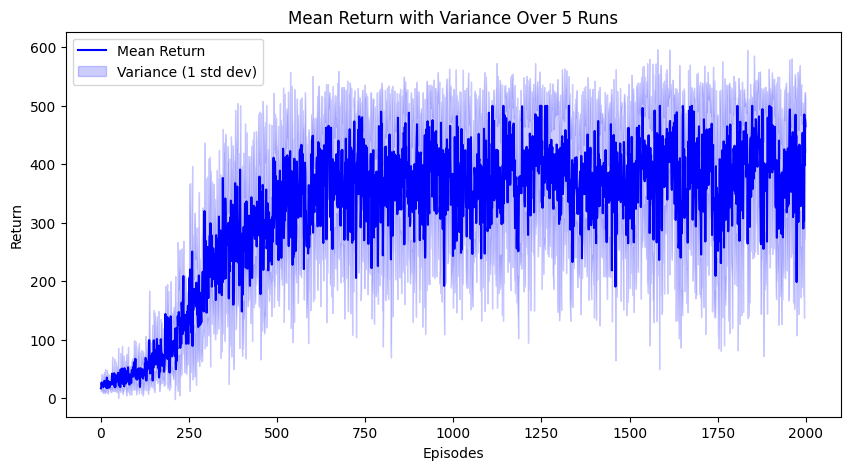

In [15]:
import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# Constants
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
MAX_EPISODES = 2000
MAX_STEPS = 500
NUM_RUNS = 5
MAX_REWARD = 500
ALPHA = 0.1
LAMBDA = 0.8

# Tile Coding Parameters
NUM_TILINGS = 20
NUM_TILES = [20, 20, 20, 20]

# State Bounds
state_bounds = [
    [-4.8, 4.8],
    [-3.0, 3.0],
    [-0.418, 0.418],
    [-3.0, 3.0]
]

def tile_encode(state):
    state_scaled = [
        (state[i] - state_bounds[i][0]) / (state_bounds[i][1] - state_bounds[i][0])
        for i in range(len(state))
    ]

    tile_indices = []
    for tiling in range(NUM_TILINGS):
        indices = []
        for i in range(len(state_scaled)):
            offset = (tiling / NUM_TILINGS) / NUM_TILES[i]
            index = int((state_scaled[i] + offset) * NUM_TILES[i]) % NUM_TILES[i]
            indices.append(index)
        tile_indices.append(tuple(indices))

    return tile_indices

def choose_action(q_table, state_tiles, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice([0, 1])

    q_values = [sum(q_table[tile][a] for tile in state_tiles) / NUM_TILINGS for a in [0, 1]]
    return np.argmax(q_values)

def sarsa_lambda(env):
    q_table = defaultdict(lambda: [0, 0])
    rewards_per_episode = []

    epsilon = EPSILON_START

    for episode in range(MAX_EPISODES):
        epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)
        state_tiles = tile_encode(env.reset()[0])
        action = choose_action(q_table, state_tiles, epsilon)
        total_reward = 0

        e_table = defaultdict(lambda: [0, 0])

        for _ in range(MAX_STEPS):
            next_state_raw, reward, terminated, truncated, _ = env.step(action)
            next_state_tiles = tile_encode(next_state_raw)
            next_action = choose_action(q_table, next_state_tiles, epsilon)

            q_next = sum(q_table[tile][next_action] for tile in next_state_tiles) / NUM_TILINGS
            td_target = reward + (GAMMA * q_next if not (terminated or truncated) else 0)

            q_current = sum(q_table[tile][action] for tile in state_tiles) / NUM_TILINGS
            td_error = td_target - q_current

            for tile in state_tiles:
                e_table[tile][action] += 1

            for tile in e_table:
                for a in [0, 1]:
                    q_table[tile][a] += ALPHA * td_error * e_table[tile][a]
                    e_table[tile][a] *= GAMMA * LAMBDA

            state_tiles, action = next_state_tiles, next_action
            total_reward += reward
            if terminated or truncated:
                break

        rewards_per_episode.append(total_reward)

        if episode % 100 == 0:
            print(f"Episode {episode}: Reward = {total_reward}, Epsilon = {epsilon:.4f}")

    return rewards_per_episode

# Run experiment
all_rewards = np.zeros((NUM_RUNS, MAX_EPISODES))

for run in range(NUM_RUNS):
    env = gym.make("CartPole-v1")
    all_rewards[run] = sarsa_lambda(env)
    print(f"Run {run + 1} complete.")

# Compute Mean and Variance
mean_rewards = np.mean(all_rewards, axis=0)
variance_rewards = np.var(all_rewards, axis=0)

# Plot Mean Return with Variance
plt.figure(figsize=(10, 5))
plt.plot(mean_rewards, label="Mean Return", color="blue")
plt.fill_between(range(MAX_EPISODES),
                 mean_rewards - np.sqrt(variance_rewards),
                 mean_rewards + np.sqrt(variance_rewards),
                 color="blue", alpha=0.2, label="Variance (1 std dev)")
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.title("Mean Return with Variance Over 5 Runs")
plt.legend()
plt.show()
